# Introduction

This Jupyter Notebook introduces [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) alongside with [KDEpy](https://kdepy.readthedocs.io/en/latest/).
Kernel density estimation is an approach to solve the following problem.

> **Problem.** Given a set of $N$ data points $\{x_1, x_2, \dots, x_N\}$, estimate the probability density function from which the data is drawn.

There are roughly two approaches to solving this problem:

1. Assume a **parametric form**, e.g. a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), and estimate the *parameters* $\mu$ and $\sigma$. These parameters uniquely determine the distribution, and are typically found using the [maximum likelihood principle](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). The advantage of this approach is that we only need to estimate a few parameters, while the disadvantage is that the chosen parametric form might not fit the data very well.
2. Use **kernel density estimation**, which is a non-parametric method -- we let the data speak for itself. The idea is to place a *kernel function* $K$ on each data point $x_i$, and let the probability density function be given by the sum of the $N$ kernel functions.

Assuming a parametric form is a perfectly valid approach, especially if there is evidence suggesting the presence of a theoretical distribution.
However, for [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) we might want to assume as little as possible when plotting a distribution, and this is where kernel density estimation and KDEpy comes to the rescue.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from KDEpy import FFTKDE  # Fastest 1D algorithm

np.random.seed(123)  # Seed generator for reproducible results

distribution = norm()  # Create normal distribution
data = distribution.rvs(32)  # Draw 32 random samples

## The histogram

A KDE may be thought of as an extension to the familiar [histogram](https://en.wikipedia.org/wiki/Histogram). 
The purpose of the KDE is to estimate an unknown probability density function $f(x)$ given data sampled from it. 
A natural first thought is to use a histogram – it’s well known, simple to understand and works reasonably well.

To see how the histogram performs on the data generated above, we'll plot the true distribution alongside a histogram. 
As seen below, the histogram does a fairly poor job, since:
- The location of the bins and the number of bins are both arbitrary.
- The estimated distribution is discontinuous (not smooth), while the true distribution is continuous (smooth).

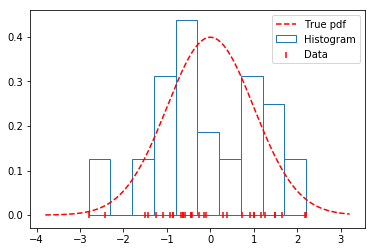

In [2]:
x = np.linspace(np.min(data) - 1, np.max(data) + 1, num=2**10)

plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.scatter(data, np.zeros_like(data), marker='|', 
            c='r', label='Data', zorder=9)
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Centering the histogram

In an effort to reduce the arbitrary placement of the histogram bins, we center a *box function* $K$ on each data point $x_i$ and average those functions to obtain a probability density function.
This is a (very simple) kernel density estimator.

$$\hat{f}(x) = \frac{1}{N} \sum_{i=1}^N K \left( x-x_i \right) \quad \text{ where } \quad K = \text{box function}$$

Since each function $K$ has $\int K \, dx = 1$, we divide by $N$ to ensure that $\int \hat{f}(x) \, dx = 1$.
A kernel density estimator with $\int \hat{f}(x) \, dx = 1$ and $\hat{f}(x) \geq 0$ for every $x$ is called a *bona fide* estimator.

Enough theory -- let's see what this looks like graphically on a simple data set.

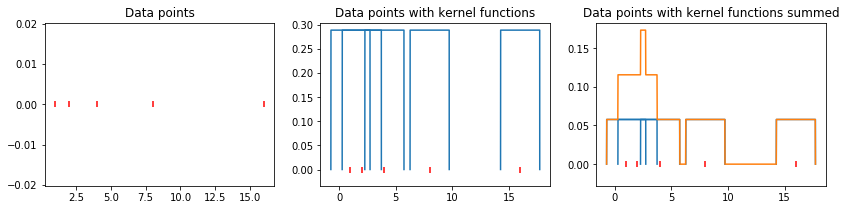

In [3]:
from KDEpy import TreeKDE
np.random.seed(123)
data = [1, 2, 4, 8, 16]

# Plot the points
plt.figure(figsize=(14, 3)); plt.subplot(1, 3, 1)
plt.title('Data points')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')

# Plot a kernel on each data point
plt.subplot(1, 3, 2); plt.title('Data points with kernel functions')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
for d in data:
    x, y = TreeKDE(kernel='box').fit([d])()
    plt.plot(x, y, color='#1f77b4')
    
# Plot a normalized kernel on each data point, and the sum
plt.subplot(1, 3, 3); plt.title('Data points with kernel functions summed')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
for d in data:
    x, y = TreeKDE(kernel='box').fit([d])()
    plt.plot(x, y / len(data), color='#1f77b4')
x, y = TreeKDE(kernel='box').fit(data)()
plt.plot(x, y, color='#ff7f0e');

Now let us grapically review our progress so far:

1. We have a collection of *data points* $\{x_1, x_2, \dots, x_N\}$.
2. These data points are drawn from a *true probability density function* $f(x)$, unknown to us.
3. A very simple way to construct an estimate $\hat{f}(x)$ is to use a *histogram*.
4. A *KDE*  $\hat{f}(x)$ *with a box kernel* is similar to a histogram, but the data chooses the location of the boxes.

Looking at the graph below, we see that the KDE with a box kernel is the most promising estimate so far.

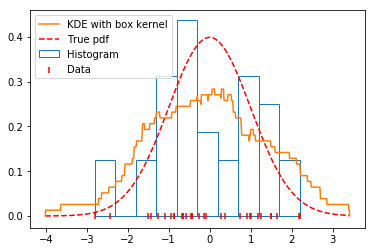

In [4]:
np.random.seed(123)
data = distribution.rvs(32)

# Use a box function with the FFTKDE to obtain a density estimate
x, y = FFTKDE(kernel='box', bw=0.7).fit(data).evaluate()

plt.plot(x, y, zorder=10, color='#ff7f0e', label='KDE with box kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', 
            label='Data', zorder=9)
plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Choosing a smooth kernel

The true function $f(x)$ is continuous, while our estimate $\hat{f}(x)$ is not.
To alleviate the problem of discontinuity, we substitute the box function used above for a gaussian function (a normal distribution). 

$$K = \text{box function} \quad \to \quad K = \text{gaussian function}$$

The gaussian is smooth, and so the result of our estimate will also be smooth.
This looks even better than our previous jagged estimate.

> **Note (Kernel functions).** Many kernel functions are available, see `FFTKDE._available_kernels.keys()` for a complete list.

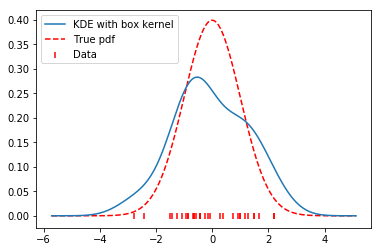

In [5]:
# Use the FFTKDE with a smooth Gaussian
x, y = FFTKDE(kernel='gaussian', bw=0.7).fit(data).evaluate()

plt.plot(x, y, zorder=10, label='KDE with box kernel')
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Selecting a suitable bandwidth

To control the bandwidth $h$ of the kernel, we'll add a factor $h >0$ to the equation above.

$$\hat{f}(x) = \frac{1}{N} \sum_{i=1}^N K \left( x-x_i \right) \quad \to \quad \hat{f}(x) = \frac{1}{N h} \sum_{i=1}^N K \left( \frac{x-x_i}{h} \right)$$

- When $h \to 0$, the estimate becomes jagged (high variance, overfitting).
- When $h \to \infty$, the estimate becomes oversmoothed (high bias, underfitting).

> **Note (Bandwidth).** The `bw` parameter is implemented so that it corresponds to the *standard deviation* $\sigma$ of the kernel function $K$. This is a design choice for consistent bandwidths across kernels with and without finite support.

> **Note (Automatic Bandwidth Selection).** Automatic bandwidth selection based on the data is available, i.e. `bw='silverman'`. For a complete listing of available routines for automatic bandwidth selection, see `FFTKDE._bw_methods.keys()`.

In general, optimal bandwidth selection is a difficult theoretical problem.

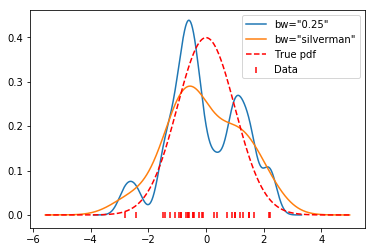

In [6]:
for bw in [0.25, 'silverman']:
    x, y = FFTKDE(kernel='gaussian', bw=bw).fit(data).evaluate()
    plt.plot(x, y, label='bw="{}"'.format(bw))
    
plt.scatter(data, np.zeros_like(data), marker='|', c='r', label='Data')
plt.plot(x, distribution.pdf(x), label='True pdf', c='r', ls='--')
plt.legend(loc='best');

## Weighted data

As a final modification to the problem, let's weight each indiviual data point $x_i$ with a weight $w_i \geq 0$.
The contribution to the sum from the data point $x_i$ is controlled by $w_i$.
We divide by $\sum_{i=1}^N w_i$ to ensure that $\int \hat{f}(x) \, dx = 1$.
Here is how the equation is transformed when we add weights.

$$\hat{f}(x) = \frac{1}{N h} \sum_{i=1}^N K \left( \frac{x - x_i}{h}  \right)$$

$$\hat{f}(x) = \frac{1}{\left( \sum_{i=1}^N w_i \right ) h} \sum_{i=1}^N w_i K \left( \frac{x - x_i}{h} \right)$$

The factor $N^{-1}$ performed uniform weighting, and is removed in favor of the $w_i$'s.

> **Note (Scaling of weights).** If the weights do not sum to unity, they will be scaled automatically by KDEpy.

Let's see how weighting can change the result.

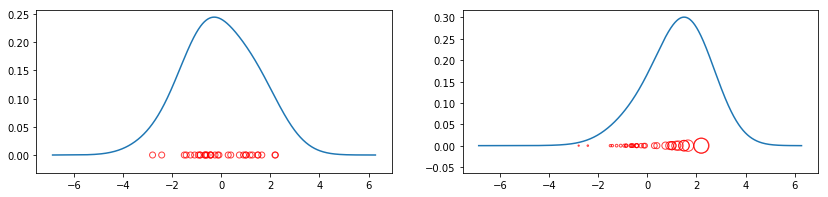

In [7]:
plt.figure(figsize=(14, 3)); plt.subplot(1, 2, 1)
plt.scatter(data, np.zeros_like(data), marker='o', c='None', 
            edgecolor='r', alpha=0.75)

# Unweighted KDE
x, y = FFTKDE().fit(data)()
plt.plot(x, y)

plt.subplot(1, 2, 2); np.random.seed(123)
weights = np.exp(data) * 25
plt.scatter(data, np.zeros_like(data), marker='o', c='None', 
            edgecolor='r', alpha=0.75, s=weights)

# Unweighted KDE
x, y = FFTKDE().fit(data, weights=weights)()
plt.plot(x, y);

## Speed

There is much more to say about kernel density estimation, but let us conclude with a speed test.

> **Note (Speed of FFTKDE).** Millions of data points pose no trouble for the FFTKDE implementation. Computational time scales **linearily** with the number of points in practical settings. The theoretical runtime is $\mathcal{O}(2^d N + n \log n)$, where $d$ is the dimension, $N$ is the number of data points and $n$ the number of grid points. With $d=1$ and $n = 2^{10}$ (the default values), $N$ dominates.

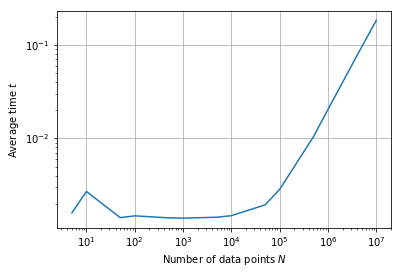

In [8]:
import time
import statistics
import itertools
import operator

def time_function(function, n=10, t=25):
    times = []
    for _ in range(t):
        data = np.random.randn(n) * 10
        weights = np.random.randn(n) ** 2
        start_time = time.perf_counter()
        function(data, weights)
        times.append(time.perf_counter() - start_time)
    
    return statistics.mean(times)

def time_FFT(data, weights):
    x, y = FFTKDE().fit(data, weights)()
    
# Generate sizes [5, 10, 50, 100, ..., 10_000_000]
data_sizes = list(itertools.accumulate([5, 2] * 7, operator.mul))

times_fft = [time_function(time_FFT, k) for k in data_sizes]
plt.loglog(data_sizes, times_fft, label='FFTKDE')

plt.xlabel('Number of data points $N$')
plt.ylabel('Average time $t$')
plt.grid(True);

In [9]:
for size, time in zip(data_sizes, times_fft):
    print('{:,}'.format(size).ljust(8), round(time, 3), sep='\t')

5       	0.002
10      	0.003
50      	0.001
100     	0.001
500     	0.001
1,000   	0.001
5,000   	0.001
10,000  	0.001
50,000  	0.002
100,000 	0.003
500,000 	0.01
1,000,000	0.02
5,000,000	0.095
10,000,000	0.183


## References